In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cf
import netCDF4
import pandas as pd
import datetime
import pytz 
from tzwhere import tzwhere
import math
from suntime import Sun

### This script is to compare the ICON output with TERRA_URB = on/off for Berlin to the observational data from DWD

In [2]:
def get_data(len_data, NU_WU):
    ds_data = {}
    for i in range(1, len_data + 1):
        filename = f'./data_all/fc_DOM01_0{i:03d}_{NU_WU}_urban_grid.nc'
        try:
            ds_data[i] = xr.open_dataset(filename)
            print(f'Successfully opened {filename}')
        except FileNotFoundError:
            print(f'File not found: {filename}')
        except Exception as e:
            print(f'An error occurred while opening {filename}: {e}')

    return ds_data

def get_data_nights(len_data, NU_WU):  #len_data is the number of files i want to read in (e.g. 4 for 4h hourly data), NU_WU is a str and you can define if you want 'with urban' or 'no urban'
    ds_data = {}  
    for i in range(1, len_data + 1):
        filename = f'./data_nights_new/fc_DOM01_0{i:03d}_{NU_WU}_urban_grid_nights.nc'
        try:
            ds_data[i] = xr.open_dataset(filename)
            print(f'Successfully opened {filename}')
        except FileNotFoundError:
            print(f'File not found: {filename}')
        except Exception as e:
            print(f'An error occurred while opening {filename}: {e}')
    
    return ds_data


def get_variable_1d(len_data, data, variable, height_level, hour): #data is the output of 'get_data', variable is e.g. 'T' (as str), height_level (mostly 1 for urban), hour is time in this case 0 because one file only has one timestep
    ds_data = {}
    for i in range(1, len_data+1):
        ds_data[i] = data[i][f'{variable}'].isel(time = hour, height_2 = height_level)
    
    return ds_data

def prepare_sun(number_cities, data, file): #number of cities depends on input and % of landuse tiles, file defines in which hour you want to define since all hours are stored in one xarray dataset
    sun = {}
    for i in range(number_cities):
        sun[i] = Sun(data[file].clat[i].to_numpy()*180/math.pi, data[file].clon[i].to_numpy()*180/math.pi)
    
    return sun

def get_sunrise_sunset(number_cities, input_time, input_sun): #input_sun is the output of 'def prepare_sun'
    sunrise = {}
    sunset = {}
    for i in range(number_cities):
        sunrise[i] = input_sun[i].get_local_sunrise_time(input_time).time()
        sunrise[i] = pytz.utc.localize(sunrise[i])
    for i in range(number_cities):
        sunset[i] = input_sun[i].get_local_sunset_time(input_time).time()
        sunset[i] = pytz.utc.localize(sunset[i])
    
    return sunrise, sunset
        

def binary_daynight(number_cities, sunrise, sunset, hour): #in this case hour is only the hour of the day (e.g. 21). The function doesn't work if there is a date, too. 
    time = datetime.time(hour)
    time = pytz.utc.localize(time)
    daynight = []
    
    for i in range(number_cities):
        if sunset[i] < sunrise[i] and sunrise[i] <= time <= sunset[i] or sunset[i] > sunrise[i] and time > sunset[i] or time < sunrise[i]:
            daynight.append('Night')
        else:
            daynight.append('Day')

    return daynight


def get_night(binary_data, data):
    data_night = {}

    for i, dataset in data.items():
        dataset = dataset.expand_dims(dim={"day_night": binary_data})
        
        data_night[i] = dataset.where(dataset['day_night'] != 'Day')
    
    return data_night, dataset

In [3]:
data_WU = get_data(120, 'WU')
data_NU = get_data(120, 'NU') 

Successfully opened ./data_all/fc_DOM01_0001_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0002_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0003_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0004_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0005_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0006_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0007_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0008_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0009_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0010_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0011_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0012_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0013_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0014_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0015_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0016_WU_urban_grid.nc
Successf

In [4]:
data_WU_nights = get_data_nights(120, 'WU')
data_NU_nights = get_data_nights(120, 'NU')

Successfully opened ./data_nights_new/fc_DOM01_0001_WU_urban_grid_nights.nc
Successfully opened ./data_nights_new/fc_DOM01_0002_WU_urban_grid_nights.nc
Successfully opened ./data_nights_new/fc_DOM01_0003_WU_urban_grid_nights.nc
Successfully opened ./data_nights_new/fc_DOM01_0004_WU_urban_grid_nights.nc
Successfully opened ./data_nights_new/fc_DOM01_0005_WU_urban_grid_nights.nc
Successfully opened ./data_nights_new/fc_DOM01_0006_WU_urban_grid_nights.nc
Successfully opened ./data_nights_new/fc_DOM01_0007_WU_urban_grid_nights.nc
Successfully opened ./data_nights_new/fc_DOM01_0008_WU_urban_grid_nights.nc
Successfully opened ./data_nights_new/fc_DOM01_0009_WU_urban_grid_nights.nc
Successfully opened ./data_nights_new/fc_DOM01_0010_WU_urban_grid_nights.nc
Successfully opened ./data_nights_new/fc_DOM01_0011_WU_urban_grid_nights.nc
Successfully opened ./data_nights_new/fc_DOM01_0012_WU_urban_grid_nights.nc
Successfully opened ./data_nights_new/fc_DOM01_0013_WU_urban_grid_nights.nc
Successfully

In [5]:
berlin_obs = pd.read_csv('produkt_air_temperature_399_akt.txt', sep = ';')
berlin_obs_date = berlin_obs[berlin_obs[' MESS_DATUM'].between(2021070419, 2021070918)]

In [6]:
len(berlin_obs_date)

120

In [7]:
berlin_obs_date

,STATIONS_ID,MESS_DATUM,QUALITAETS_NIVEAU,STRUKTUR_VERSION,LUFTTEMPERATUR,REL_FEUCHTE,STRAHLUNGSTEMPERATUR,eor
51134,399,2021070419,3,0,24.8,46,-999,eor ...
51135,399,2021070420,3,0,23.7,49,-999,eor ...
51136,399,2021070421,3,0,23.0,51,-999,eor ...
51137,399,2021070422,3,0,22.3,54,-999,eor ...
51138,399,2021070423,3,0,21.9,55,-999,eor ...
...,...,...,...,...,...,...,...,...
51249,399,2021070914,3,0,22.1,79,-999,eor ...
51250,399,2021070915,3,0,20.2,84,-999,eor ...
51251,399,2021070916,3,0,18.5,85,-999,eor ...
51252,399,2021070917,3,0,18.1,85,-999,eor ...


#### Find Berlin cell

## Idea: go through same loop identifying nights with the observations as with the ICON output (maybe it is going to be a little bit more difficult but i have lan lot)

In [8]:
#prepare sun

sun_WU = {}
sun_NU = {}

for i in range(1, 120):
    sun_WU[i] = prepare_sun(247, data_WU, i)
    
for i in range(1, 120):
    sun_NU[i] = prepare_sun(247, data_NU, i)

In [9]:
#get sunrise sunset

sunrise_WU = {}
sunrise_NU = {}

sunset_WU = {}
sunset_NU = {}

time_zone = datetime.date(2021,7,4)

for i in range(1, 120):
    sunrise_WU[i], sunset_WU[i] = get_sunrise_sunset(247, time_zone , sun_WU[i])

for i in range(1,120):
    sunrise_NU[i], sunset_NU[i] = get_sunrise_sunset(247, time_zone , sun_NU[i])

In [10]:
time_array = []

for i in range(121):
    time_array.append(i % 24)

numbers_to_add = [0, 21, 22, 23]  # Numbers to add

# Use the insert method to add numbers to the beginning of the array
for num in reversed(numbers_to_add):
    time_array.insert(0, num)

print(time_array[120])

20


In [11]:
#be careful: i added a 0 in the beginning of time_array so the indexing is correct. Not a nice way but is working..

daynight_WU = {}
daynight_NU = {}

#time_array = [0,21, 22, 23, 24, 1, 2]

for i in range(1, 120):
    j = time_array[i]
    daynight_WU[i] = binary_daynight(247, sunrise_WU[i], sunset_WU[i], j)
    
for i in range(1, 120):
    j = time_array[i]
    daynight_NU[i] = binary_daynight(247, sunrise_NU[i], sunset_NU[i], j)

In [12]:
data_variable = {}

for i in range(1,119):
    
    data_variable[i] = xr.DataArray(daynight_WU[i], dims=('cell',), coords={'cell': data_WU[i]['cell']})
    data_WU[i]['daynight'] = data_variable[i]

for i in range(1,119):
    
    data_variable[i] = xr.DataArray(daynight_NU[i], dims=('cell',), coords={'cell': data_NU[i]['cell']})
    data_NU[i]['daynight'] = data_variable[i]

In [13]:
data_WU[1]['clon'][74].to_numpy()*180/math.pi

13.332689020693993

In [14]:
data_WU[1]['clat'][74].to_numpy()*180/math.pi

52.518943506229135

In [15]:
T_2M_WU = get_variable_1d(119, data_WU, 'T_2M', 0 , 0)
T_2M_NU = get_variable_1d(119, data_NU, 'T_2M', 0 , 0)

T_2M_WU_nights = get_variable_1d(118, data_WU_nights, 'T_2M', 0 , 0)
T_2M_NU_nights = get_variable_1d(118, data_NU_nights, 'T_2M', 0 , 0)

In [16]:
#T_2M_WU_daynight = get_variable_1d(119, data_WU, 'daynight', 0 , 0)
#T_2M_NU_daynight = get_variable_1d(119, data_NU, 'daynight', 0 , 0)

In [20]:
T_2M_berlin ={}

T_WU_values = [None]
T_NU_values = [None]
T_WU_time = [None]

for i in range(1,120):
    T_WU_values.append(T_2M_WU[i][74])
    T_NU_values.append(T_2M_NU[i][74])
    
for i in range(1,120):
    T_WU_time.append(T_2M_WU[i]['time'])
    
T_2M_berlin['T_WU'] = np.array(T_WU_values) 
T_2M_berlin['T_NU'] = np.array(T_NU_values) 
T_2M_berlin['hour_test'] =np.array(T_WU_time)
T_2M_berlin['hour'] = berlin_obs_date.iloc[:,1]
T_2M_berlin['obs'] = berlin_obs_date.iloc[:,4]

In [18]:
T_2M_berlin ={}

T_WU_values = [None]
T_NU_values = [None]
T_WU_time = [None]

for i in range(1,120):
    T_WU_values.append(data_WU[74]['Daynight'])
    T_NU_values.append(T_2M_NU[i][74])

KeyError: 'Daynight'

In [27]:

#berlin_obs_date['berlin_obs_date'] = berlin_obs_date['berlin_obs_date'].str.replace('24', '00')
#berlin_obs_date['berlin_obs_date'] = pd.to_datetime(berlin_obs_date['berlin_obs_date'], format="%Y%m%d%H")

In [ ]:
T_2M_berlin_nights ={}

T_WU_values_nights = [None]
T_NU_values_nights = [None]
T_WU_time_night = [None]

for i in range(1,119):
    T_WU_values_nights.append(T_2M_WU_nights[i][74])
    T_NU_values_nights.append(T_2M_NU_nights[i][74])

for i in range(1,120):
    T_WU_time_night.append(T_2M_WU[i]['time'])
    
T_2M_berlin_nights['T_WU'] = np.array(T_WU_values_nights) 
T_2M_berlin_nights['T_NU'] = np.array(T_NU_values_nights)
#_2M_berlin_nights['hour_test'] =np.array(T_WU_time_night)
T_2M_berlin_nights['hour'] = time_array

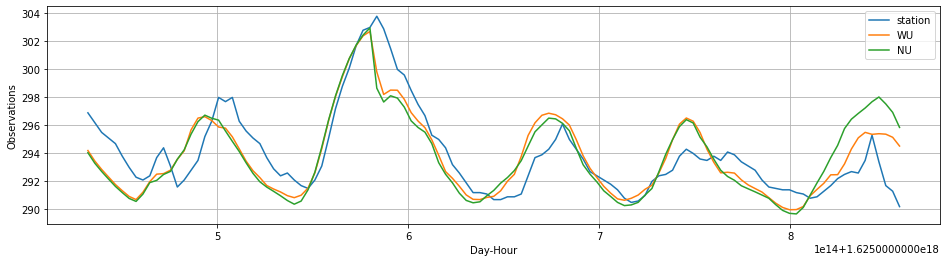

<Figure size 432x288 with 0 Axes>

In [29]:
fig = plt.figure(figsize=(16,4))
ax = fig.gca()


# Plot the data
ax.plot(T_2M_berlin['hour_test'], T_2M_berlin['obs']+273.15, label = 'station')
ax.plot(T_2M_berlin['hour_test'], T_2M_berlin['T_WU'], label = 'WU')
ax.plot(T_2M_berlin['hour_test'], T_2M_berlin['T_NU'], label = "NU")

#locator = mdates.HourLocator(interval=12)
#formatter = mdates.DateFormatter('%Y%m%d%H')
#ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_major_formatter(formatter)
#plt.xticks(rotation=45)
ax.grid()
ax.legend()

ax.set_xlabel('Day-Hour')
ax.set_ylabel('Observations')

plt.show()
plt.savefig('./plots/comparison_berlin_cliamte_station_allday.jpeg', dpi=300)

In [ ]:
print(np.mean(abs(T_2M_berlin['obs']+273.15 - T_2M_berlin['T_WU'])))
print(np.std(abs(T_2M_berlin['obs']+273.15 - T_2M_berlin['T_WU'])))

In [ ]:
print(np.mean(abs(T_2M_berlin['obs']+273.15 - T_2M_berlin['T_NU'])))
print(np.std(abs(T_2M_berlin['obs']+273.15 - T_2M_berlin['T_NU'])))

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.gca()

ax.plot(T_2M_berlin['hour_test'], (T_2M_berlin['obs']+273.15 - T_2M_berlin['T_WU']) - (T_2M_berlin['obs']+273.15 - T_2M_berlin['T_NU']) , label = 'station WU')

#locator = mdates.HourLocator(interval=6)
#formatter = mdates.DateFormatter("%d %H:%M")
#ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_major_formatter(formatter)
#plt.xticks(rotation=45)
ax.grid()
ax.legend()
ax.axhline(y=0, color='black', linestyle='-')

ax.set_xlabel('Day-Hour')
ax.set_ylabel('Observations')

plt.show()